In [1]:
using VMLS
using LinearAlgebra

## Chapter 11
# Matrix inverses
### 11.1 Left and right inverses
We’ll see later how to find a left or right inverse, when one exists.

In [2]:
A = [-3 -4; 4 6; 1 1]
B = [-11 -10 16; 7 8 -11]/9 # A left inverse of A
C = [0 -1 6; 0 1 -4]/2 # Another left inverse of A;
A

3×2 Matrix{Int64}:
 -3  -4
  4   6
  1   1

In [3]:
B

2×3 Matrix{Float64}:
 -1.22222   -1.11111    1.77778
  0.777778   0.888889  -1.22222

In [4]:
C

2×3 Matrix{Float64}:
 0.0  -0.5   3.0
 0.0   0.5  -2.0

In [5]:
# Let’s check
B*A, C*A

([1.0 0.0; -4.440892098500626e-16 0.9999999999999996], [1.0 0.0; 0.0 1.0])

### 11.2 Inverse

If `A` is invertible, its inverse is given by `inv(A)` (and also `A^-1`). You’ll get an error if `A` is not invertible, or not square.

In [6]:
A = [1 -2 3; 0 2 2; -4 -4 -4]
B = inv(A)
B*A

3×3 Matrix{Float64}:
 1.0  0.0          0.0
 0.0  1.0          2.77556e-17
 0.0  5.55112e-17  1.0

In [7]:
A*B

3×3 Matrix{Float64}:
  1.0           1.11022e-16  0.0
  5.55112e-17   1.0          1.38778e-17
 -1.11022e-16  -2.22045e-16  1.0

**Dual basis.** The next example illustrates the dual basis provided by the rows of the inverse $B = A^{−1}$. We calculate the expansion $x = (b^T_1 x)a_1 + · · ·+ (b^T_nx)a_n$ for a $3 × 3$ example (see page [205](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.249) of VMLS).

In [8]:
A = [ 1 0 1; 4 -3 -4; 1 -1 -2]

3×3 Matrix{Int64}:
 1   0   1
 4  -3  -4
 1  -1  -2

In [9]:
B = inv(A)

3×3 Matrix{Float64}:
  2.0  -1.0   3.0
  4.0  -3.0   8.0
 -1.0   1.0  -3.0

In [10]:
x = [ 0.2, -0.3, 1.2]

3-element Vector{Float64}:
  0.2
 -0.3
  1.2

In [11]:
rhs = (B[1,:]'*x) * A[:,1] + (B[2,:]'*x) * A[:,2] + (B[3,:]'*x) * A[:,3]

3-element Vector{Float64}:
  0.1999999999999993
 -0.29999999999999716
  1.200000000000001

**Inverse via QR factorization.** The inverse of a matrix $A$ can be computed from
its $QR$ factorization $A = QR$ via the formula $A^{−1} = R^{−1}Q^T$.

In [12]:
A = randn(3,3);
inv(A)

3×3 Matrix{Float64}:
 -1.45282   0.777279  0.704602
 -0.478106  0.212672  1.01611
 -0.948302  1.01037   0.175663

In [13]:
Q, R = qr(A);
Q = Matrix(Q);
inv(R)*Q'

3×3 Matrix{Float64}:
 -1.45282   0.777279  0.704602
 -0.478106  0.212672  1.01611
 -0.948302  1.01037   0.175663

In [14]:
diff = inv(A) .- inv(R)*Q'
[abs(round(x)) for x in diff]

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

### 11.3 Solving linear equations
**Back substitution.** Let’s first implement back substitution (VMLS Algorithm [11.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#algorithmctr.11.1)) in Julia, and check it. You won’t need this function, since Julia has a better implementation of it built in (via the backslash operation discussed below). We give it here only to demonstrate that it works.

In [15]:
function back_subst(R,b)
n = length(b)
x = zeros(n)
for i=n:-1:1
x[i] = (b[i] - R[i,i+1:n]'*x[i+1:n]) / R[i,i]
end
return x
end

back_subst (generic function with 1 method)

In [16]:
R = triu(randn(4,4)) # Random 4x4 upper triangular matrix

4×4 Matrix{Float64}:
 1.40513  -0.425698  -1.1232     0.736444
 0.0      -0.121381   0.108442   0.237875
 0.0       0.0       -0.251507   1.98363
 0.0       0.0        0.0       -0.495441

In [17]:
b = rand(4);
x = back_subst(R,b);
norm(R*x-b)

1.5700924586837751e-15

The function `triu` gives the upper triangular part of a matrix, i.e., it zeros out the entries below the diagonal. 

**Backslash notation.** The Julia command for solving a set of linear equations $$Ax = b$$ is `x=A\b`. This is faster than `x=inv(A)*b`, which first computes the inverse of $A$ and then multiplies it with $b$.

In [18]:
n = 5000;
A = randn(n,n); b = randn(n); # random set of equations
@time x1 = A\b;
norm(b-A*x1)

  1.133438 seconds (968.09 k allocations: 254.618 MiB, 1.30% gc time, 32.12% compilation time)


3.4705760405262585e-9

In [19]:
@time x2 = inv(A)*b;
norm(b-A*x2)

  2.490758 seconds (8 allocations: 193.253 MiB, 2.17% gc time)


2.289418152608903e-9

Julia chooses a suitable algorithm for solving the equation after checking the
properties of $A$. For example, it will use back substitution if $A$ is lower triangular.
This explains the result in the following timing experiment.

In [20]:
n = 5000;
b = randn(n);
A = tril(randn(n,n)); # random lower triangular matrix
@time x = A\b;
A = randn(n,n); # random square matrix
@time x = A\b;
n = 10000;
b = randn(n);
A = tril(randn(n,n)); # random lower triangular matrix
@time x = A\b;
A = randn(n,n); # random square matrix
@time x = A\b;

  0.013853 seconds (2 allocations: 39.172 KiB)
  0.772526 seconds (6 allocations: 190.811 MiB)
  0.049309 seconds (2 allocations: 78.172 KiB)
 16.979523 seconds (6 allocations: 763.092 MiB, 0.35% gc time)


When we double the size from $n = 5000$ to $n = 10000$, the solution time for the
triangular equation increases from $0.04$ seconds to $1.29$ seconds. This is a factor of
about four, consistent with the $n^2$ complexity of backsubstitution. For the general
square system, the solution times increases from $0.16$ seconds to $9.01$ seconds, i.e.,
a factor of roughly eight, as we would expect given the order $n^3$ complexity.
Factor-solve methods for multiple right-hand sides. A linear equation is solved
by first factorizing $A$ and then solving several simpler equations with the factors
of $A$. This is referred to as a factor-solve scheme. An important application is the
solution of multiple linear equations with the same coefficient matrix and different
right-hand sides.

In [21]:
n = 5000;
A = randn(n,n); B = randn(n,2);
# Solve with right-hand side B[:,1]
@time x1 = A \ B[:,1];
# Solve with right-hand side B[:,2]
@time x2 = A \ B[:,2];
# Naive approach for solving A*X = B
@time X = [ A\B[:,1] A\B[:,2] ];
# Factor-solve approach
@time X = A \ B;

  2.318546 seconds (21.47 k allocations: 192.322 MiB, 1.00% compilation time)
  2.331112 seconds (9 allocations: 190.850 MiB)
  4.673407 seconds (141.40 k allocations: 391.594 MiB, 2.27% gc time, 1.69% compilation time)
  2.355886 seconds (87.04 k allocations: 196.696 MiB, 5.14% compilation time)


The factor-solve approach finds the solutions for the two right-hand sides in roughly
the same time as the solution for one right-hand side. The solution time with the
naïve approach is twice the time for one right-hand side.

### 11.4 Examples
**Polynomial interpolation.** We compute the interpolating polynomials in Figure [11.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.11.1) of VMLS. The following code uses the functions vandermonde and linspace from the `VMLS` package. (Th function `linspace(a,b,n)` returns a vector with `n` equally spaced numbers in the interval [a, b].) The result is shown in Figure 11.1.

In [22]:
t = [ -1.1, -0.4, 0.2, 0.8 ];
A = vandermonde(t, 4)

4×4 Matrix{Float64}:
 1.0  -1.1  1.21  -1.331
 1.0  -0.4  0.16  -0.064
 1.0   0.2  0.04   0.008
 1.0   0.8  0.64   0.512

In [23]:
b1 = [ -1.0, 1.3, 1.0, 0.5 ];
c1 = A \ b1

4-element Vector{Float64}:
  1.210956879377932
 -0.8883105198894671
 -1.1096651886125564
  1.3864790180579651

In [24]:
b2 = [ 1.0, 0.0, -2.0, 0 ];
c2 = A \ b2

4-element Vector{Float64}:
 -1.5412891202364891
 -3.1090546880020575
  3.33847439110597
  3.695135274082643

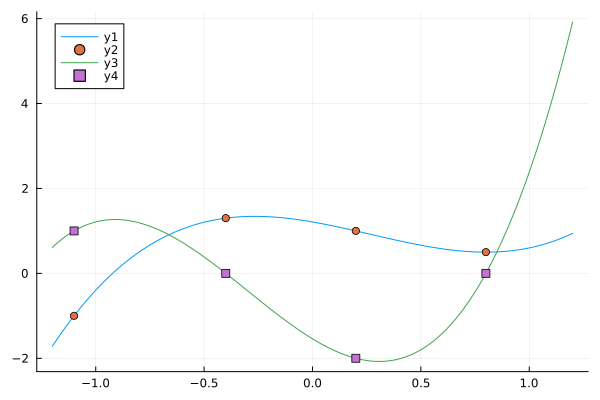

In [25]:
using Plots
ts = linspace(-1.2, 1.2, 1000);
p1 = c1[1] .+ c1[2]*ts + c1[3]*ts.^2 + c1[4]*ts.^3;
plot(ts, p1)
scatter!(t, b1)
p2 = c2[1] .+ c2[2]*ts + c2[3]*ts.^2 + c2[4]*ts.^3;
plot!(ts, p2)
scatter!(t, b2, marker = :square)

**Figure 11.1** Cubic interpolants through two sets of points, shown as circles
and squares.

### 11.5 Pseudo-inverse
In Julia, the pseudo-inverse of a matrix `A` is obtained with `pinv(A)`. We compute the pseudo-inverse for the example on page [216](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.270) of VMLS using the `pinv` function, and via the formula $A† = R^{−1}Q^{T}$ , where $A = QR$ is the $QR$ factorization of $A$. 

In [26]:
A = [-3 -4; 4 6; 1 1]
pinv(A)

2×3 Matrix{Float64}:
 -1.22222   -1.11111    1.77778
  0.777778   0.888889  -1.22222

In [27]:
Q, R = qr(A);
Q = Matrix(Q)

3×2 Matrix{Float64}:
 -0.588348  -0.457604
  0.784465  -0.522976
  0.196116   0.719092

In [28]:
R

2×2 Matrix{Float64}:
 5.09902   7.2563
 0.0      -0.588348

In [29]:
R \ Q' # pseudo-inverse from QR factors

2×3 Matrix{Float64}:
 -1.22222   -1.11111    1.77778
  0.777778   0.888889  -1.22222